In [17]:
import pandas as pd
import numpy as np
from os import path
from CSVUtils import *
import ta
import matplotlib.pyplot as plt
import seaborn as sn
import calendar
from pprint import pprint
import pickle

In [18]:
DIR = "./from github/Stock-Trading-Environment/data"
nameList = ["^BVSP", "^TWII", "^IXIC"]
df_list = []
startDate = pd.to_datetime("2015-01-01")
endDate = pd.to_datetime("2019-12-31")

for name in nameList:
    df = csv2df(csv_path=DIR, csv_name=name+".csv", source="yahoo")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.dropna()
    df_list.append(df)

In [19]:
twd_df = pd.read_csv("./input/currency/TWD_1995-2020.csv")
brl_df = pd.read_csv("./input/currency/BRL_1995-2020.csv")

twd_df['Date'] = pd.to_datetime(twd_df['Date'])
brl_df['Date'] = pd.to_datetime(brl_df['Date'])

twd_change = twd_df[['Date','Change']]
brl_change = brl_df[['Date','Change']]

In [20]:
def stem_df(df, intersect_dates, startDate, endDate):
    df.dropna(inplace = True)
    df = df[df['Date'].isin(intersect_dates)].reset_index(drop=True)
    df = df[(df['Date'] >= startDate) & (df['Date'] <= endDate)]
    df = df.reset_index(drop=True)
    return df

In [21]:
intersect_dates = df_list[0]['Date']
for df in df_list[1:]+[twd_change,brl_change]:
    df.dropna(inplace = True)
    intersect_dates = np.intersect1d(intersect_dates, df['Date'])

/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
for i, df in enumerate(df_list):
    df_list[i] = stem_df(df, intersect_dates, startDate, endDate)
twd_change = stem_df(twd_change, intersect_dates, startDate, endDate)
brl_change = stem_df(brl_change, intersect_dates, startDate, endDate)

/Users/lzcai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
df_list[0]['FX Change'] = brl_change['Change']
df_list[1]['FX Change'] = twd_change['Change']
df_list[2]['FX Change'] = 0

In [24]:
for i, df in enumerate(df_list):
    df['Cum FX Change'] = (df['FX Change']+1).cumprod()
    df['Actual Price'] = df['Price']*df['Cum FX Change']

In [25]:
df_list[2].head()

,Date,Open,High,Low,Price,Vol,Change,FX Change,Cum FX Change,Actual Price
0,2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,1794470000,-0.015706,0,1,4652.569824
1,2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,2167320000,-0.012859,0,1,4592.740234
2,2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,1957950000,0.012570,0,1,4650.470215
3,2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,2105450000,0.018432,0,1,4736.189941
4,2015-01-09,4744.470215,4744.709961,4681.240234,4704.069824,1715830000,-0.006782,0,1,4704.069824


In [27]:
pickle.dump(df_list, open("0306-adjusted market prices.out", "wb"))

In [26]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [27]:
annual_rebalance_date = ["12-31"]
semiAnnual_rebalance_date = ["06-30", "12-31"]
quarter_rebalance_date = ["03-31", "06-30", "09-30", "12-31"]
monthly_rebalance_date = ["01-31", "02-28", "03-31", "04-30", "05-31", "06-30", "07-31", "08-31", "09-30", "10-31", "11-30", "12-31"]

In [28]:
# For nominal prices:
init_net_worth = 300000
avg_net_worth = init_net_worth / (len(df_list))
asset_list = nameList
init_price_arr = np.array([df['Price'][0] for df in df_list])
init_num_arr = np.array([avg_net_worth / price for price in init_price_arr])

init_status_list = []
for i, asset in enumerate(asset_list):
    status = {
        'Asset': asset_list[i],
        'Number': init_num_arr[i],
        'Price': init_price_arr[i],
        'Net Value': avg_net_worth,
        'Delta Number': init_num_arr[i],
    }
    init_status_list.append(status)

COMMISSION_RATE = 0
prev_num_arr = init_num_arr
result_list = []
net_value_list = []

start_year = startDate.year
final_year = endDate.year
rebalance_freq = ['annual_rebalance', 
                  'semiAnnual_rebalance', 
                  'quarter_rebalance', 
                  'monthly_rebalance']

final_result = []
for j, balance_date in enumerate(
    [annual_rebalance_date, semiAnnual_rebalance_date, quarter_rebalance_date, monthly_rebalance_date]):
    result_list = []
    
    # 1. Init the final result and the holding number
    result_list.append({
        'Date': df_list[0]['Date'][0],
        'Record': init_status_list
    })
    
    prev_num_arr = init_num_arr
    net_value_list = []
    
    # 2. Get rebalance data
    for year in range(start_year, final_year+1):
        for date_str in balance_date:
            # 1) Determine the rebalance date
            rebalance_date = pd.to_datetime(str(year)+'-'+date_str)
            
            
            # 2) Getting the price of the nearest date after the rebalance date
            price_list = []
            
            if not (df_list[0]['Date']>=rebalance_date).any(): # Means there is no existing record after the rebalance date
                print("break on ", rebalance_date)
                break
            
            nearest_date_after = nearest(df_list[0]['Date'][df_list[0]['Date']>=rebalance_date], rebalance_date)

            for df in df_list:
                price_list.append(df['Price'][df.Date==nearest_date_after].values[0])

            # 3) Calculate the buy and sell number
            price_arr = np.array(price_list)
            current_net_worth = sum(prev_num_arr*price_arr)
            current_nominal_num_arr = (current_net_worth/len(asset_list))/price_arr

            delta_num_arr = current_nominal_num_arr - prev_num_arr

            sell_num_arr = delta_num_arr*(delta_num_arr<0)*-1
            buy_num_arr = delta_num_arr*(delta_num_arr>0)

            sell_cash = np.sum(sell_num_arr*price_arr)*(1-COMMISSION_RATE)

            buy_budget_proposed = buy_num_arr*price_arr
            buy_ratio = buy_budget_proposed/np.sum(buy_budget_proposed)
            buy_budget_actual = buy_ratio*sell_cash
            buy_num_arr_actual = buy_budget_actual / (price_arr*(1+COMMISSION_RATE))

            # 4. Update the inventory
            current_num_arr = prev_num_arr-sell_num_arr+buy_num_arr_actual

            status_list = []
            for i, asset in enumerate(asset_list):
                status = {
                    'Asset': asset_list[i],
                    'Number': current_num_arr[i],
                    'Price': price_arr[i],
                    'Net Value': current_num_arr[i]*price_arr[i],
                    'Delta Number': current_num_arr[i]-prev_num_arr[i],
                }
                status_list.append(status)

            prev_num_arr = current_num_arr

            result_list.append({
                'Date': nearest_date_after,
                'Record': status_list
            })

            net_value_list.append({
                'Date': nearest_date_after,
                'Net Value': current_net_worth
            })


    final_result.append(result_list)
    print(rebalance_freq[j])

nominal_price_result = final_result
print("Done")


break on  2019-12-31 00:00:00
annual_rebalance
break on  2019-12-31 00:00:00
semiAnnual_rebalance
break on  2019-12-31 00:00:00
quarter_rebalance
break on  2019-12-31 00:00:00
monthly_rebalance
Done


In [29]:
# For actual prices:
init_net_worth = 300000
avg_net_worth = init_net_worth / (len(df_list))
asset_list = nameList
init_price_arr = np.array([df['Actual Price'][0] for df in df_list])
init_num_arr = np.array([avg_net_worth / price for price in init_price_arr])

init_status_list = []
for i, asset in enumerate(asset_list):
    status = {
        'Asset': asset_list[i],
        'Number': init_num_arr[i],
        'Price': init_price_arr[i],
        'Net Value': avg_net_worth,
        'Delta Number': init_num_arr[i],
    }
    init_status_list.append(status)

COMMISSION_RATE = 0.00125
prev_num_arr = init_num_arr
result_list = []
net_value_list = []

start_year = startDate.year
final_year = endDate.year
rebalance_freq = ['annual_rebalance', 
                  'semiAnnual_rebalance', 
                  'quarter_rebalance', 
                  'monthly_rebalance']

final_result = []
for j, balance_date in enumerate(
    [annual_rebalance_date, semiAnnual_rebalance_date, quarter_rebalance_date, monthly_rebalance_date]):
    result_list = []
    
    # 1. Init the final result and the holding number
    result_list.append({
        'Date': df_list[0]['Date'][0],
        'Record': init_status_list
    })
    
    prev_num_arr = init_num_arr
    net_value_list = []
    
    # 2. Get rebalance data
    for year in range(start_year, final_year+1):
        for date_str in balance_date:
            # 1) Determine the rebalance date
            rebalance_date = pd.to_datetime(str(year)+'-'+date_str)
            
            
            # 2) Getting the price of the nearest date after the rebalance date
            price_list = []
            
            if not (df_list[0]['Date']>=rebalance_date).any(): # Means there is no existing record after the rebalance date
                print("break on ", rebalance_date)
                break
            
            nearest_date_after = nearest(df_list[0]['Date'][df_list[0]['Date']>=rebalance_date], rebalance_date)

            for df in df_list:
                price_list.append(df['Actual Price'][df.Date==nearest_date_after].values[0])

            # 3) Calculate the buy and sell number
            price_arr = np.array(price_list)
            current_net_worth = sum(prev_num_arr*price_arr)
            current_nominal_num_arr = (current_net_worth/len(asset_list))/price_arr

            delta_num_arr = current_nominal_num_arr - prev_num_arr

            sell_num_arr = delta_num_arr*(delta_num_arr<0)*-1
            buy_num_arr = delta_num_arr*(delta_num_arr>0)

            sell_cash = np.sum(sell_num_arr*price_arr)*(1-COMMISSION_RATE)

            buy_budget_proposed = buy_num_arr*price_arr
            buy_ratio = buy_budget_proposed/np.sum(buy_budget_proposed)
            buy_budget_actual = buy_ratio*sell_cash
            buy_num_arr_actual = buy_budget_actual / (price_arr*(1+COMMISSION_RATE))

            # 4. Update the inventory
            current_num_arr = prev_num_arr-sell_num_arr+buy_num_arr_actual

            status_list = []
            for i, asset in enumerate(asset_list):
                status = {
                    'Asset': asset_list[i],
                    'Number': current_num_arr[i],
                    'Price': price_arr[i],
                    'Net Value': current_num_arr[i]*price_arr[i],
                    'Delta Number': current_num_arr[i]-prev_num_arr[i],
                }
                status_list.append(status)

            prev_num_arr = current_num_arr

            result_list.append({
                'Date': nearest_date_after,
                'Record': status_list
            })

            net_value_list.append({
                'Date': nearest_date_after,
                'Net Value': current_net_worth
            })


    final_result.append(result_list)
    print(rebalance_freq[j])

actual_price_result = final_result
print("Done")


break on  2019-12-31 00:00:00
annual_rebalance
break on  2019-12-31 00:00:00
semiAnnual_rebalance
break on  2019-12-31 00:00:00
quarter_rebalance
break on  2019-12-31 00:00:00
monthly_rebalance
Done


In [14]:
import pickle
pickle.dump([nominal_price_result, actual_price_result], open("0306-currency adjusted rebalance record.out", "wb"))

In [30]:
[tmp['Net Value'] for tmp in actual_price_result[0][0]['Record']]

[100000.0, 100000.0, 100000.0]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


NameError: name 'record' is not defined

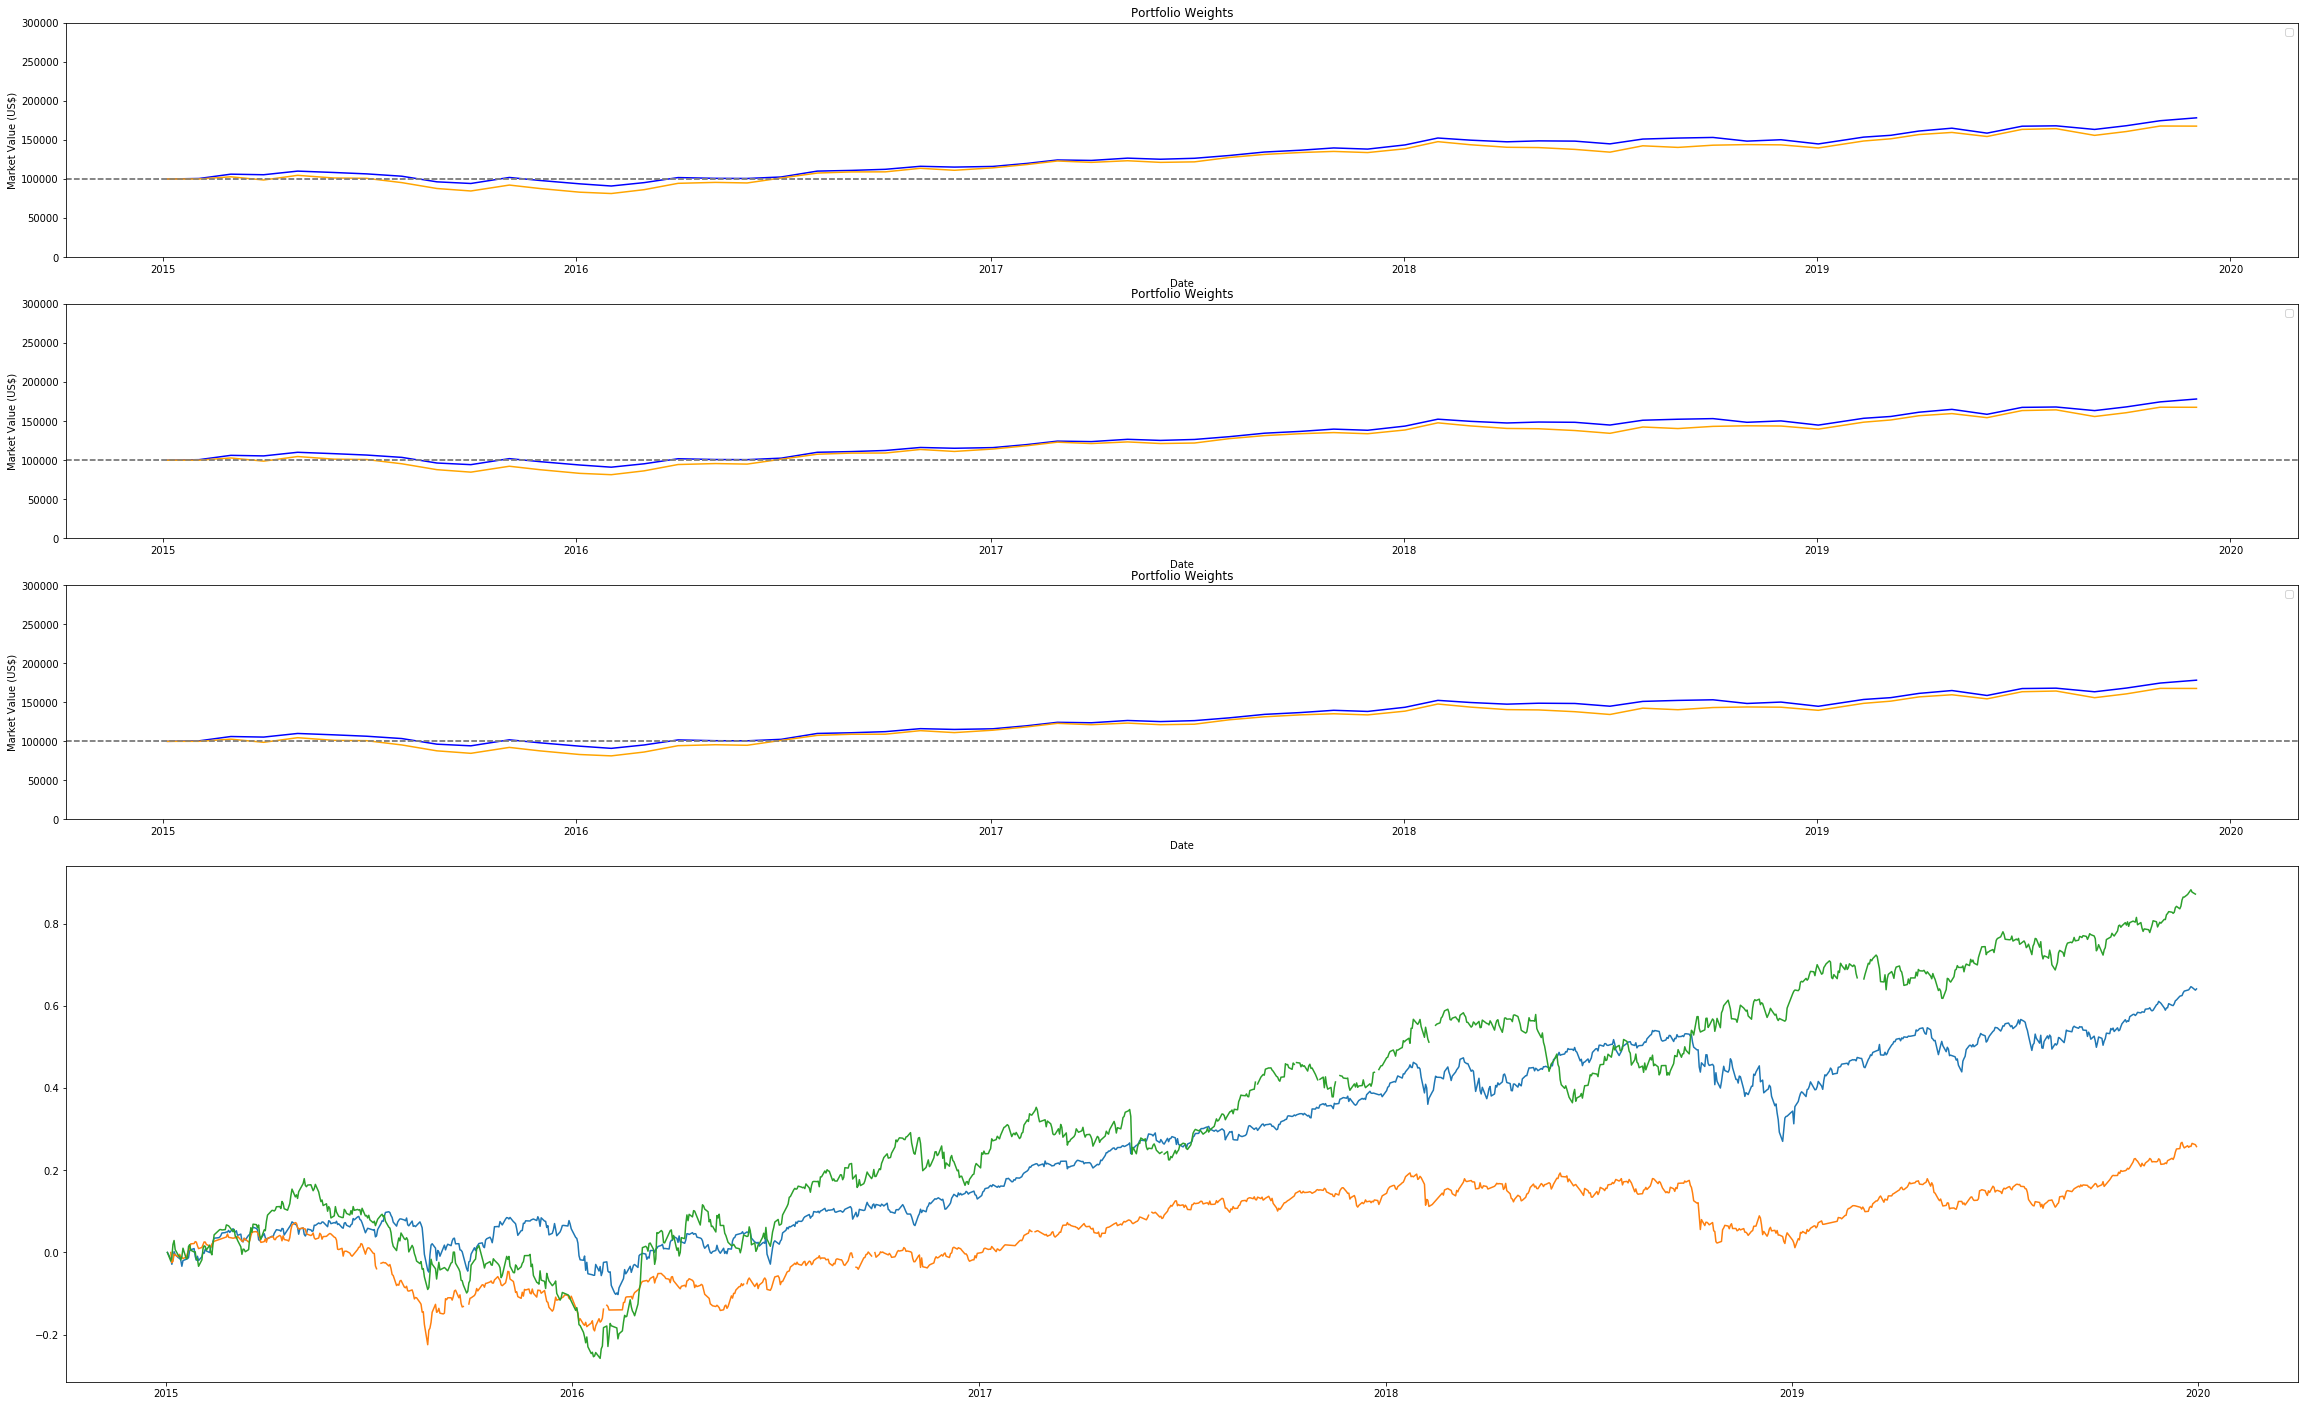

In [36]:
nominal = nominal_price_result[3]
actual = actual_price_result[3]

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec


nominal_labels = ["high-^BVSP", "mid-^TWII", "low-^IXIC"]
actual_labels = ["high-^BVSP_act", "mid-^TWII_act", "low-^IXIC"]

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
fig=plt.figure(figsize=(40,25))

gs=GridSpec(5,1) # 5 rows, 1 columns
axs=[]
axs.append(fig.add_subplot(gs[0,0])) # First row, first column
axs.append(fig.add_subplot(gs[1,0])) # First row, second column
axs.append(fig.add_subplot(gs[2,0])) # First row, third column
axs.append(fig.add_subplot(gs[3:,:])) # Second row, span all columns




x = np.array([tmp['Date'] for tmp in nominal])
record_list = [tmp['Record'] for tmp in nominal]
z = []
for tmp_record in record_list:
    z.append([tmp['Net Value'] for tmp in tmp_record])
z = np.array(z)
b = np.transpose(z)
for i in range(len(b)):
    axs[i].plot(x, b[i], color = "blue")



for i in range(3):
    axs[i].axhline(y=100000, color = "grey", linestyle='--')
    axs[i].set_ylim((0, 300000))
    axs[i].legend()
    axs[i].set_title('Portfolio Weights')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Market Value (US$)')
    

    
    
x = np.array([tmp['Date'] for tmp in actual])
record_list = [tmp['Record'] for tmp in actual]
z = []
for tmp_record in record_list:
    z.append([tmp['Net Value'] for tmp in tmp_record])
z = np.array(z)
b = np.transpose(z)
for i in range(len(b)):
    axs[i].plot(x, b[i], color = "orange")



for i in range(3):
    axs[i].axhline(y=100000, color = "grey", linestyle='--')
    axs[i].set_ylim((0, 300000))
    axs[i].legend()
    axs[i].set_title('Portfolio Weights')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Market Value (US$)')
    
    
    
    
DIR = "./from github/Stock-Trading-Environment/data"
if False:
    file_names = ["^BVSP_new", "^TWII_new", "^IXIC"]
    source_list = ["done", "done", "yahoo"]
else:
    file_names = ["^BVSP", "^TWII", "^IXIC"]
    source_list = ["yahoo", "yahoo", "yahoo"]

labels = ["high-", "mid-", "low-"]

# axs[1].figure(figsize = (40,15))
for i in range(2,-1,-1): # Inverse: Low-Mid-High
    df = csv2df(DIR, file_names[i]+".csv",source = source_list[i])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date']>=pd.to_datetime("2015-01-01"))&(df['Date']<=pd.to_datetime("2019-12-31"))].reset_index(drop=True)

    j = 0
    init_price = df['Price'][j]
    while np.isnan(init_price):
        j+=1
        init_price = df['Price'][j]
    y = np.log(df['Price'][j:] / init_price)
    x = df['Date'][j:]
    axs[3].plot(x,y,label = labels[i]+file_names[i])

axs[3].plot([tmp['date'] for tmp in record], np.log([tmp['total_net_worth'] for tmp in record]/record[0]['total_net_worth']), label = "RL Portfolio")
axs[3].axhline(y=0, color = "grey", linestyle='--')
axs[3].set_ylim((-1,1))
axs[3].legend()
axs[3].set_title('Log Market Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('log(Market Price)')
plt.show()

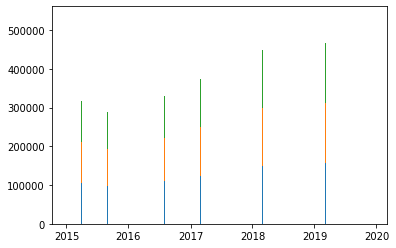

In [141]:
a = np.array([tmp['Date'] for tmp in final_result[3]])
    
record_list = [tmp['Record'] for tmp in final_result[3]]
z = []
for record in record_list:
    z.append([tmp['Net Value'] for tmp in record])
z = np.array(z)
b = np.transpose(z)
b_dict = {}
for i in range(len(b)):
    if i == 0:
        plt.bar(a, b[i], width=0.9)
        b_dict[i] = b[i]
    else:
        plt.bar(a, b[i],bottom=b_dict[i-1], width=0.9)
        b_dict[i] = b_dict[i-1]+b[i]

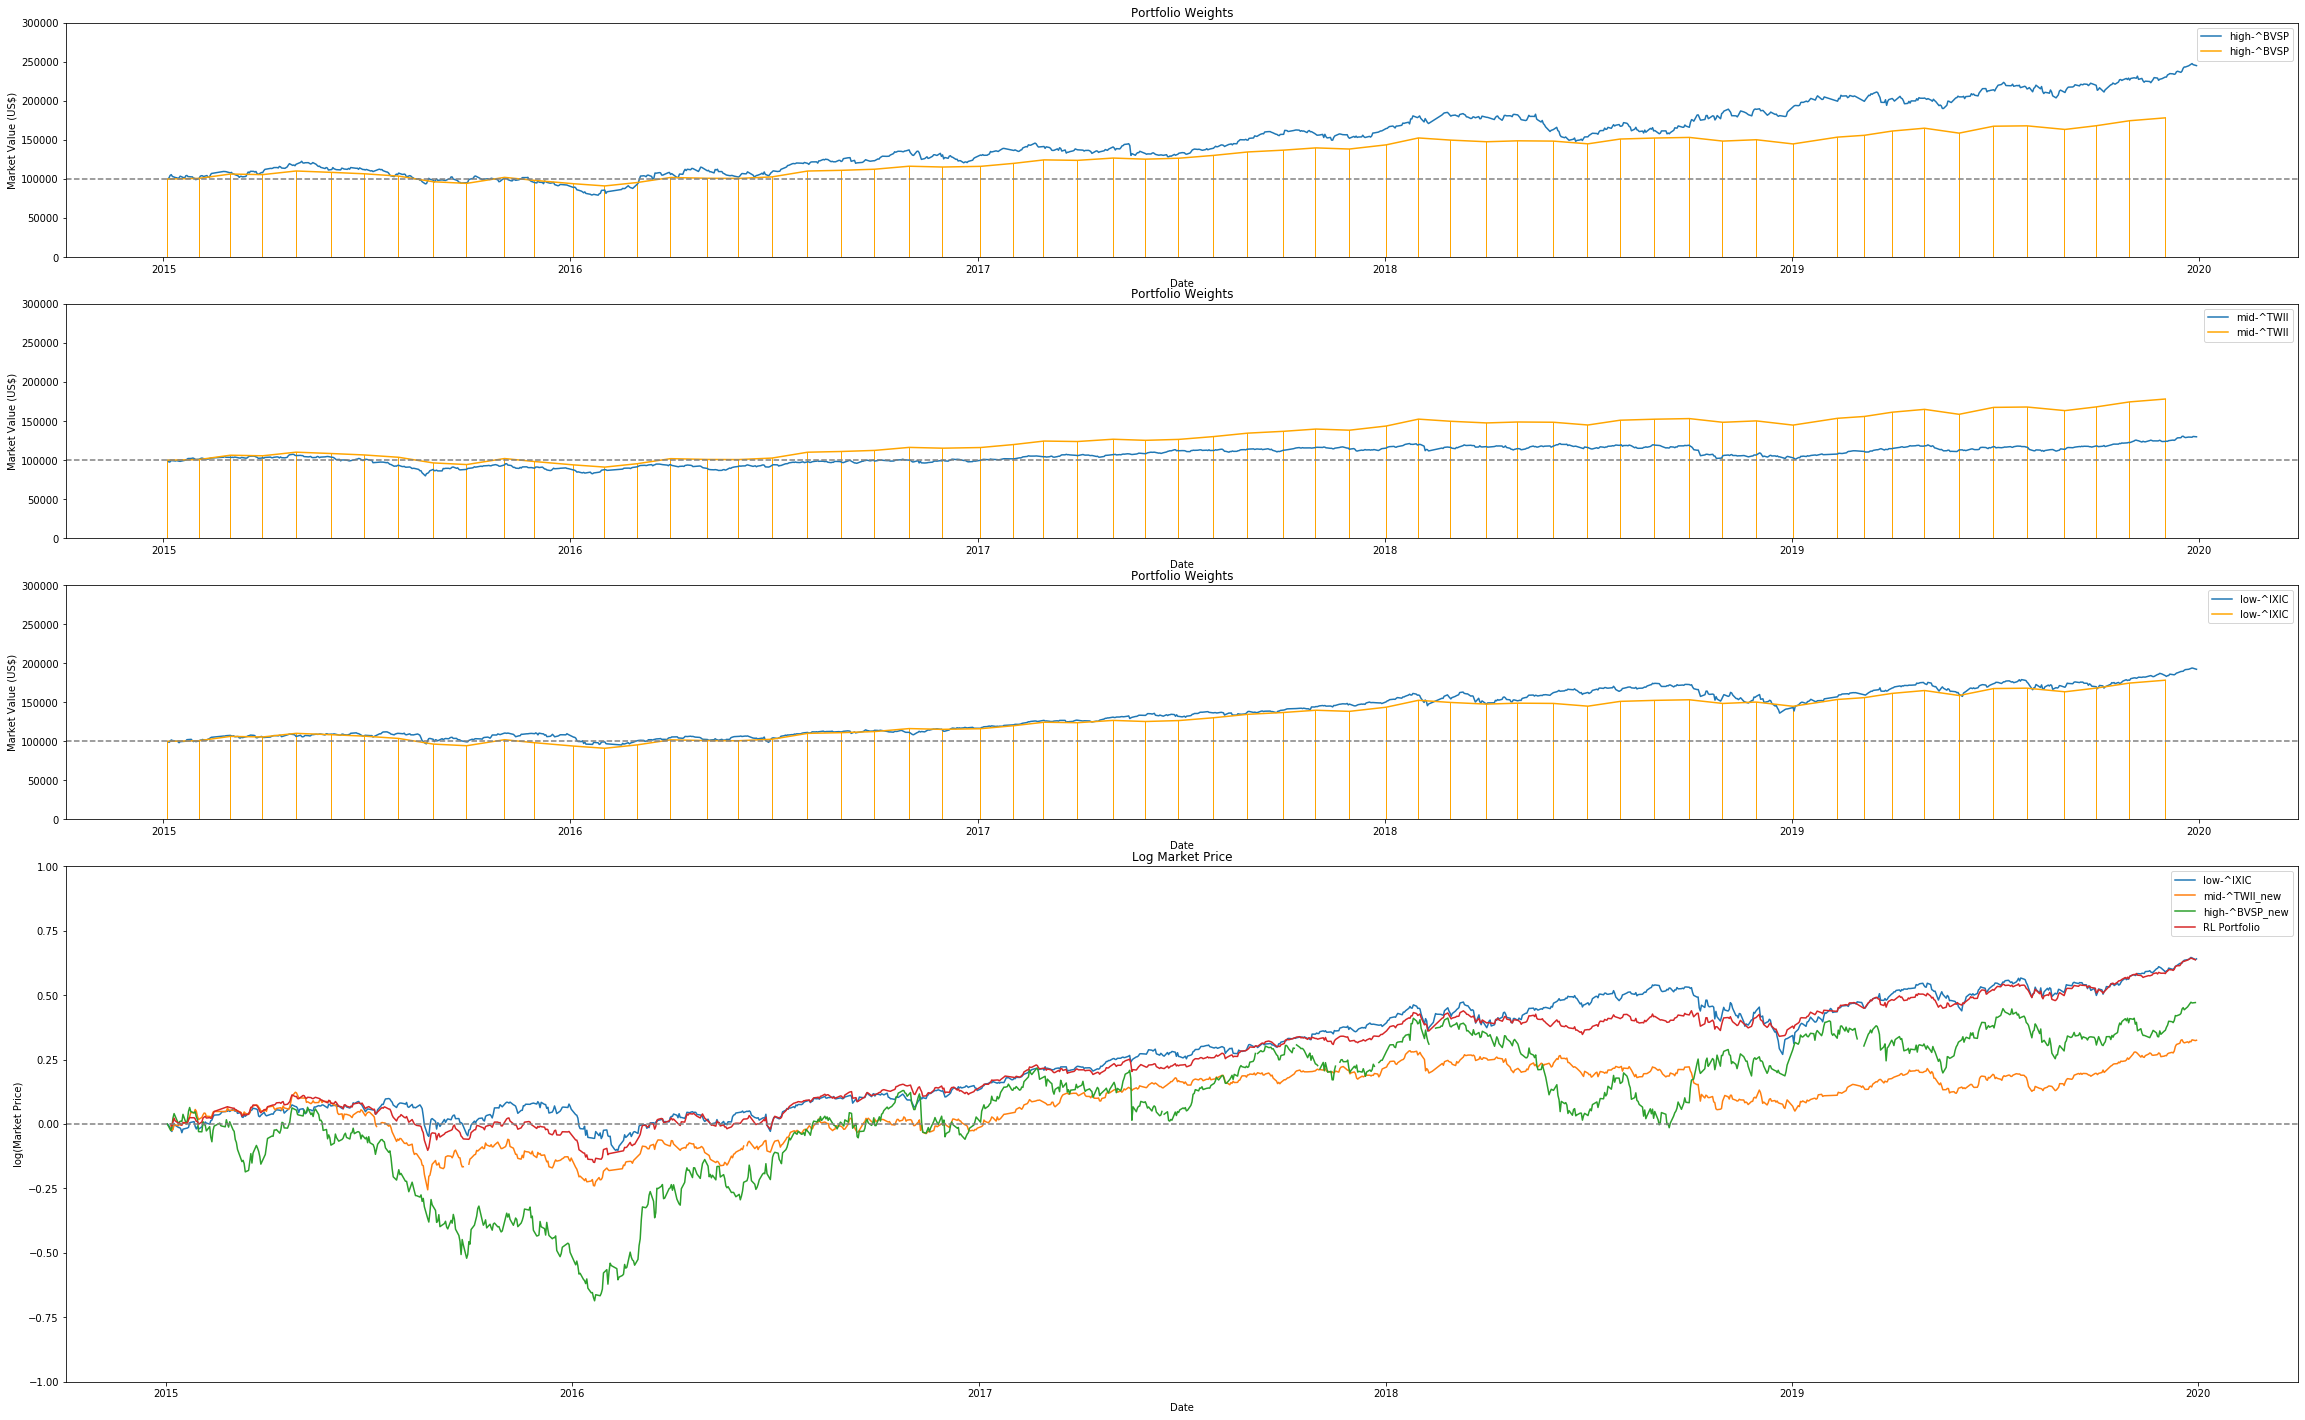

In [187]:
(record, transactions, title, currency) = (plot_list, final_result[3], "Model Behavior Analysis",True)


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(40,25))

gs=GridSpec(5,1) # 5 rows, 1 columns

axs[0]=fig.add_subplot(gs[0,0]) # First row, first column
axs[1]=fig.add_subplot(gs[1,0]) # First row, second column
axs[2]=fig.add_subplot(gs[2,0]) # First row, third column
axs[3]=fig.add_subplot(gs[3:,:]) # Second row, span all columns



labels = ["high-^BVSP", "mid-^TWII", "low-^IXIC"]

# x&y: Market Price
x = np.array([tmp['date'] for tmp in record])
y_bottom = {}
plt.rcParams['figure.facecolor'] = 'white'
# plt.suptitle(title, fontsize=16)

width = 0.9
for i in range(2,-1,-1): # Inverse: Low-Mid-High
    y = np.array([tmp['inv_net_worth'][i] for tmp in record])
    if i == 2:
        axs[i].plot(x, y, label=labels[i])
    else:
        axs[i].plot(x, y, label =labels[i])


# a&b: Execution Price
a = np.array([tmp['Date'] for tmp in transactions])
tr_record_list = [tmp['Record'] for tmp in transactions]
z = []
for tmp_record in tr_record_list:
    z.append([tmp['Net Value'] for tmp in tmp_record])
z = np.array(z)
b = np.transpose(z)
b_bottom = {}

for i in range(2,-1,-1): # Inverse: Low-Mid-High
    axs[i].plot(a, b[i], label=labels[i], color="orange")
    axs[i].bar(a, b[i], width, color="orange")

for i in range(3):
    axs[i].axhline(y=100000, color = "grey", linestyle='--')
    axs[i].set_ylim((0, 300000))
    axs[i].legend()
    axs[i].set_title('Portfolio Weights')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Market Value (US$)')




DIR = "./from github/Stock-Trading-Environment/data"
if currency:
    file_names = ["^BVSP_new", "^TWII_new", "^IXIC"]
    source_list = ["done", "done", "yahoo"]
else:
    file_names = ["^BVSP", "^TWII", "^IXIC"]
    source_list = ["yahoo", "yahoo", "yahoo"]

labels = ["high-", "mid-", "low-"]

# axs[1].figure(figsize = (40,15))
for i in range(2,-1,-1): # Inverse: Low-Mid-High
    df = csv2df(DIR, file_names[i]+".csv",source = source_list[i])
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date']>=pd.to_datetime("2015-01-01"))&(df['Date']<=pd.to_datetime("2019-12-31"))].reset_index(drop=True)

    j = 0
    init_price = df['Price'][j]
    while np.isnan(init_price):
        j+=1
        init_price = df['Price'][j]
    y = np.log(df['Price'][j:] / init_price)
    x = df['Date'][j:]
    axs[3].plot(x,y,label = labels[i]+file_names[i])

axs[3].plot([tmp['date'] for tmp in record], np.log([tmp['total_net_worth'] for tmp in record]/record[0]['total_net_worth']), label = "RL Portfolio")
axs[3].axhline(y=0, color = "grey", linestyle='--')
axs[3].set_ylim((-1,1))
axs[3].legend()
axs[3].set_title('Log Market Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('log(Market Price)')
plt.show()


In [104]:
# Process data for plotting graph

# for bal_result in final_result:

# Init the dates
rebal_result = pd.DataFrame(final_result[3])
rebal_date_arr = np.array(rebal_result['Date'])
start_date = rebal_date_arr[0]
end_date = list(df_list[0]['Date'])[-1]
current_date = start_date
plot_list = []

# Iterate for all dates
while current_date <= end_date:
    if current_date in rebal_date_arr:
        asset_record_list = rebal_result[rebal_result['Date']==current_date]['Record'][0]
        inv_net_worth = np.array([tmp['Net Value'] for tmp in asset_record_list])
        inv_number = np.array([tmp['Number'] for tmp in asset_record_list])
        record = {
            'date': current_date,
            'price': inv_net_worth/inv_number,
            'inv_number':inv_number,
            'inv_net_worth': inv_net_worth,
            'total_net_worth': np.sum(inv_net_worth)
        }
    else:
        last_record = plot_list[-1]
        if (current_date == df_list[0]['Date']).any():
            inv_number = last_record['inv_number']
            price_df = [tmp_df[tmp_df['Date']==current_date] for tmp_df in df_list]
            
            if any([tmp.empty for tmp in price_df]):
                current_date += pd.Timedelta(days=1)
                continue
            
            price = np.array([tmp['Price'].values[0] for tmp in price_df])
            inv_net_worth = price*inv_number
            record = {
                'date': current_date,
                'price': price,
                'inv_number':inv_number,
                'inv_net_worth': inv_net_worth,
                'total_net_worth': np.sum(inv_net_worth)
            }
        else:
            current_date += pd.Timedelta(days=1)
            continue
    plot_list.append(record)
    current_date += pd.Timedelta(days=1)

In [ ]:
plot_comparison(plot_list[1], "Model Behavior Analysis-100k-7(8)",currency=True)

In [ ]:
plot_comparison(plot_list[2], "Model Behavior Analysis-100k-7(8)",currency=True)

In [ ]:
plot_comparison(plot_list[3], "Model Behavior Analysis-100k-7(8)",currency=True)